In [ ]:
# Basic data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# Progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    Conv2DTranspose,
    Reshape,
    Input,
    Activation,
    LeakyReLU,
    BatchNormalization,
    Dropout,
    Resizing
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# For eval.:
import torch
import torchvision.models as models
from torchvision import transforms

from scipy import linalg
from PIL import Image
from glob import glob
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
NOISE_DIM = 100
BATCH_SIZE = 16
STEPS_PER_EPOCH = 16 
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)
MAIN_DIR = "drive/MyDrive/MT/archive/Training/pituitary_tumor"

# <a id='load'>Loading & Preprocessing images:</a>

In [ ]:
def load_images(folder):
    imgs = []
    target = 1  # initial label
    labels = []

    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

data, labels = load_images(MAIN_DIR)
data.shape, labels.shape


((1457, 128, 128), (1457,))

In [ ]:
X_train = data
X_train = (X_train.astype('float32') - 127.5) / 127.5 #normalize
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS) #reshape
X_train.shape

(1457, 128, 128, 1)

# <a id='gen'>Pix2Pix GAN:</a>

In [ ]:
def build_generator():
    inputs = Input(shape=(128, 128, 1))

    # Encoder
    e1 = Conv2D(64, 4, strides=2, padding='same')(inputs)  # 64x64
    e1 = LeakyReLU(0.2)(e1)

    e2 = Conv2D(128, 4, strides=2, padding='same')(e1)    # 32x32
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)

    e3 = Conv2D(256, 4, strides=2, padding='same')(e2)    # 16x16
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(0.2)(e3)

    # Decoder
    d1 = Conv2DTranspose(128, 4, strides=2, padding='same')(e3)  # 32x32
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.5)(d1)
    d1 = Concatenate()([d1, e2])
    d1 = LeakyReLU(0.2)(d1)

    d2 = Conv2DTranspose(64, 4, strides=2, padding='same')(d1)   # 64x64
    d2 = BatchNormalization()(d2)
    d2 = Concatenate()([d2, e1])
    d2 = LeakyReLU(0.2)(d2)

    d3 = Conv2DTranspose(1, 4, strides=2, padding='same')(d2)    # 128x128
    outputs = Activation('tanh')(d3)

    return Model(inputs, outputs)

def build_discriminator():
    input_img = Input(shape=(128, 128, 1))
    target_img = Input(shape=(128, 128, 1))

    x = Concatenate()([input_img, target_img])

    x = Conv2D(64, 4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model([input_img, target_img], outputs)

class GAN:
    def __init__(self):
        self.generator = build_generator()
        self.discriminator = build_discriminator()

        #fix: lower lr for stability!
        self.g_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)

    def train_step(self, real_images):
        batch_size = real_images.shape[0]

        # Train discriminator
        with tf.GradientTape() as tape:
            generated_images = self.generator(real_images, training=True)

            real_output = self.discriminator([real_images, real_images], training=True)
            fake_output = self.discriminator([real_images, generated_images], training=True)

            # Label smoothing
            real_labels = tf.ones_like(real_output) * 0.9
            fake_labels = tf.zeros_like(fake_output) + 0.1

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, real_output))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, fake_output))
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Train generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(real_images, training=True)
            fake_output = self.discriminator([real_images, generated_images], training=True)

            g_loss_gan = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))
            g_loss_l1 = 100 * tf.reduce_mean(tf.abs(real_images - generated_images))
            g_loss = g_loss_gan + g_loss_l1

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return d_loss, g_loss

    def train(self, X_train, epochs=30, batch_size=16):
        dataset = tf.data.Dataset.from_tensor_slices(X_train)
        dataset = dataset.shuffle(1000).batch(batch_size)

        for epoch in range(epochs):
            d_losses = []
            g_losses = []

            for batch in dataset:
                d_loss, g_loss = self.train_step(batch)
                d_losses.append(d_loss)
                g_losses.append(g_loss)

            print(f"Epoch {epoch+1}: D Loss = {tf.reduce_mean(d_losses):.4f}, G Loss = {tf.reduce_mean(g_losses):.4f}")


In [ ]:
gan = GAN()
gan.train(X_train, epochs=30, batch_size=32)

Epoch 1: D Loss = 0.3918, G Loss = 35.4170
Epoch 2: D Loss = 0.3580, G Loss = 14.7133
Epoch 3: D Loss = 0.4718, G Loss = 8.4477
Epoch 4: D Loss = 0.7365, G Loss = 5.5570
Epoch 5: D Loss = 0.7058, G Loss = 4.8524
Epoch 6: D Loss = 0.7008, G Loss = 4.4728
Epoch 7: D Loss = 0.6985, G Loss = 4.1195
Epoch 8: D Loss = 0.6962, G Loss = 3.9334
Epoch 9: D Loss = 0.6953, G Loss = 3.7977
Epoch 10: D Loss = 0.6943, G Loss = 3.6003
Epoch 11: D Loss = 0.6941, G Loss = 3.5905
Epoch 12: D Loss = 0.6939, G Loss = 3.4217
Epoch 13: D Loss = 0.6932, G Loss = 3.4128
Epoch 14: D Loss = 0.6933, G Loss = 3.3002
Epoch 15: D Loss = 0.6920, G Loss = 3.2172
Epoch 16: D Loss = 0.6918, G Loss = 3.2038
Epoch 17: D Loss = 0.6924, G Loss = 3.1432
Epoch 18: D Loss = 0.6921, G Loss = 3.1245
Epoch 19: D Loss = 0.6919, G Loss = 3.0236
Epoch 20: D Loss = 0.6910, G Loss = 3.0027
Epoch 21: D Loss = 0.6920, G Loss = 2.9638
Epoch 22: D Loss = 0.6925, G Loss = 2.9502
Epoch 23: D Loss = 0.6911, G Loss = 2.8700
Epoch 24: D Loss =

In [ ]:
gan.generator.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 64, 64, 64)     │          1,088 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_83            │ (None, 64, 64, 64)     │              0 │ conv2d_70[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 32, 32, 128)    │        131,200 │ leaky_re_lu_83[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 32, 32, 128)    │            512 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_84            │ (None, 32, 32, 128)    │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 16, 16, 256)    │        524,544 │ leaky_re_lu_84[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 16, 16, 256)    │          1,024 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_85            │ (None, 16, 16, 256)    │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_39       │ (None, 32, 32, 128)    │        524,416 │ leaky_re_lu_85[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_84    │ (None, 32, 32, 128)    │            512 │ conv2d_transpose_39[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 32, 32, 128)    │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 32, 32, 256)    │              0 │ dropout_25[0][0],      │
│ (Concatenate)             │                        │                │ leaky_re_lu_84[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_86            │ (None, 32, 32, 256)    │              0 │ concatenate_17[0][0]   │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_40  

 Total params: 1,447,809 (5.52 MB)

 Trainable params: 1,446,657 (5.52 MB)

 Non-trainable params: 1,152 (4.50 KB)

save weights:

In [ ]:
gan.generator.save_weights('drive/MyDrive/results/GAN_pix_2/gen_weights_pituitary_tumor.weights.h5')
gan.discriminator.save_weights('drive/MyDrive/results/GAN_pix_2/discr_weights_pituitary_tumor.weights.h5')

save images:

In [ ]:
def generate_and_save_images(gan_model, input_data, num_images=1457, save_dir='drive/MyDrive/results/GAN_pix_2/Training4/pituitary_tumor'):
 
    # to make directory!
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    #Create dataset iterator
    dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(1)
    iterator = iter(dataset)

    # Generate + save images
    for i in range(num_images):
        try:
            input_image = next(iterator) # Get next input image
        except StopIteration:
            # reset the iterator:
            iterator = iter(dataset)
            input_image = next(iterator)

        generated_image = gan_model.generator(input_image, training=False)

        # convert from [-1,1] to [0,1] range
        generated_image = (generated_image[0].numpy() + 1) * 0.5
#save:
        save_path = os.path.join(save_dir, f'generated_image_{i+1:03d}.png')
        tf.keras.utils.save_img(save_path, generated_image)

        #for progress track:
        if (i + 1) % 10 == 0:
            print(f'Saved {i+1}/{num_images} images')

In [ ]:
generate_and_save_images(gan, X_train, num_images=1457)

Saved 10/1457 images
Saved 20/1457 images
Saved 30/1457 images
Saved 40/1457 images
Saved 50/1457 images
Saved 60/1457 images
Saved 70/1457 images
Saved 80/1457 images
Saved 90/1457 images
Saved 100/1457 images
Saved 110/1457 images
Saved 120/1457 images
Saved 130/1457 images
Saved 140/1457 images
Saved 150/1457 images
Saved 160/1457 images
Saved 170/1457 images
Saved 180/1457 images
Saved 190/1457 images
Saved 200/1457 images
Saved 210/1457 images
Saved 220/1457 images
Saved 230/1457 images
Saved 240/1457 images
Saved 250/1457 images
Saved 260/1457 images
Saved 270/1457 images
Saved 280/1457 images
Saved 290/1457 images
Saved 300/1457 images
Saved 310/1457 images
Saved 320/1457 images
Saved 330/1457 images
Saved 340/1457 images
Saved 350/1457 images
Saved 360/1457 images
Saved 370/1457 images
Saved 380/1457 images
Saved 390/1457 images
Saved 400/1457 images
Saved 410/1457 images
Saved 420/1457 images
Saved 430/1457 images
Saved 440/1457 images
Saved 450/1457 images
Saved 460/1457 imag

# <a id='gen'>FID & IS scores:</a>

In [ ]:
class GANEvaluator:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.device = device
        #load the inception model:
        self.inception = models.inception_v3(pretrained=True, transform_input=False)
        self.inception.to(device)
        self.inception.eval() #put to eval

        self.transform = transforms.Compose([
            transforms.Resize(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def load_images_from_folder(self, folder_path): #double check
        images = []
        image_files = glob(os.path.join(folder_path, '*.[jp][pn][gf]*'))

        for img_path in tqdm(image_files):
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img).unsqueeze(0)
                images.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

        if images:
            return torch.cat(images, dim=0)
        return None

#get features form Inception model:
    def get_inception_features(self, images, batch_size=32):
        n_samples = images.shape[0]
        features = []

        # Set model to eval mode and disable auxiliary logits (?)
        self.inception.eval()
        if hasattr(self.inception, 'aux_logits'):
            self.inception.aux_logits = False

        for i in range(0, n_samples, batch_size):
            batch = images[i:i + batch_size].to(self.device)
            with torch.no_grad():
                # Get logits directly without aux_logits
                feat = self.inception(batch)
                if isinstance(feat, tuple):
                    feat = feat[0]
                # Apply softmax to get probabilities
                feat = torch.nn.functional.softmax(feat, dim=1)
            features.append(feat.cpu().numpy())

        features = np.concatenate(features, axis=0)
        return features

#get IS:
    def calculate_inception_score(self, images, n_splits=10, eps=1e-16):
        
        # Get probabilities
        probs = self.get_inception_features(images)
        probs = np.maximum(probs, eps) 
        probs = probs / np.sum(probs, axis=1, keepdims=True)

        scores = []
        n_images = probs.shape[0]
        split_size = n_images // n_splits

        for i in range(n_splits):
            part = probs[i * split_size:(i + 1) * split_size]
            py = np.mean(part, axis=0)
            scores.append(np.mean(np.sum(part * (np.log(part + eps) - np.log(py + eps)), axis=1)))

        return np.exp(np.mean(scores)), np.exp(np.std(scores))

    def calculate_activation_statistics(self, images):
        features = self.get_inception_features(images)
        mu = np.mean(features, axis=0)
        sigma = np.cov(features, rowvar=False)
        return mu, sigma

    def calculate_fid(self, real_images, gen_images): #between real + generated imgs
        mu1, sigma1 = self.calculate_activation_statistics(real_images)
        mu2, sigma2 = self.calculate_activation_statistics(gen_images)

        # Calculate FID:
        ssdiff = np.sum((mu1 - mu2) ** 2)
        covmean = linalg.sqrtm(sigma1.dot(sigma2))

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
        return fid

    def evaluate_single_class(self, real_folder, gen_folder, max_images=None):
        #define transform that ensures exact size?
        transform = transforms.Compose([
            transforms.Resize((299, 299)),  # Force exact size instead of shorter edge
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

        #load images with limit
        def load_limited_images(folder):
            images = []
            image_files = glob(os.path.join(folder, '*.[jp][pn][gf]*'))

            if max_images:
                image_files = image_files[:max_images]
                print(f"Using {len(image_files)} images (limited by max_images)")
            else:
                print(f"Found {len(image_files)} images")

            for img_path in tqdm(image_files):
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = transform(img).unsqueeze(0)  # Use local transform
                    images.append(img)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue

            if images:
                return torch.cat(images, dim=0)
            return None

        print("\nLoading real images...")
        real_images = load_limited_images(real_folder)
        print("\nLoading generated images...")
        gen_images = load_limited_images(gen_folder)

        if real_images is None or gen_images is None:
            print("Error: Failed to load images")
            return None

        # Match the number of real and generated images
        min_images = min(len(real_images), len(gen_images))
        real_images = real_images[:min_images]
        gen_images = gen_images[:min_images]
        print(f"\nUsing {min_images} images from each set")

        print("\nCalculating Inception Score...")
        is_mean, is_std = self.calculate_inception_score(gen_images)
        print("Calculating FID...")
        fid = self.calculate_fid(real_images, gen_images)

        results = {
            'inception_score': (is_mean, is_std),
            'fid': fid,
            'n_images': min_images
        }

        print("\n=== RESULTS ===")
        print(f"Inception Score: {is_mean:.3f} ± {is_std:.3f}")
        print(f"FID Score: {fid:.3f}")
        print(f"Number of images used: {min_images}")

        return results

FID + IS for glioma:

In [ ]:
evaluator = GANEvaluator()

real_base_path = "drive/MyDrive/MT/archive/Training"  
generated_base_path = "drive/MyDrive/results/GAN_pix_2/Training2"  


real_class_path = "drive/MyDrive/MT/archive/Training/glioma_tumor" #change for each
gen_class_path = "drive/MyDrive/results/GAN_pix_2/Training2/glioma_tumor"

results = evaluator.evaluate_single_class(real_class_path, gen_class_path, max_images=1000)

if results is not None:  
    is_mean, is_std = results['inception_score']  # Unpack the tuple
    print(f"Inception Score: {is_mean:.3f} ± {is_std:.3f}")
    print(f"FID Score: {results['fid']:.3f}")
    print(f"Number of images used: {results['n_images']}")

visualize imgs: (compare with trivial aug.)

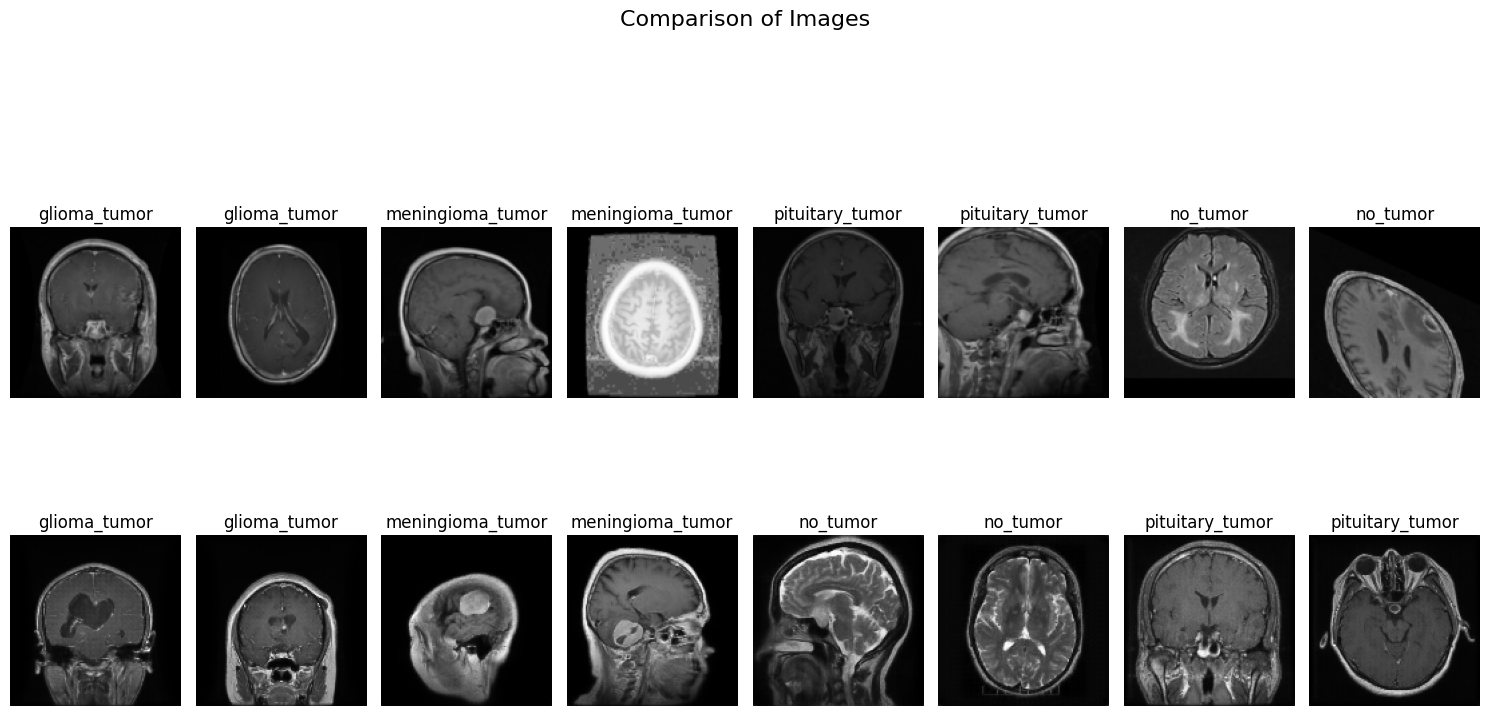

In [ ]:
def load_and_display_random_images(trivial_dir, gan_dir, images_per_folder=2):
 
    trivial_images_by_folder = {}
    gan_images_by_folder = {}

    #trivial directory
    for subdir in os.listdir(trivial_dir):
        subdir_path = os.path.join(trivial_dir, subdir)
        if os.path.isdir(subdir_path):
            folder_images = []
            for img_name in os.listdir(subdir_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(subdir_path, img_name)
                    folder_images.append((img_path, subdir))
            if folder_images:
                selected = random.sample(folder_images, min(images_per_folder, len(folder_images)))
                trivial_images_by_folder[subdir] = selected

    # GAN directory
    for subdir in os.listdir(gan_dir):
        subdir_path = os.path.join(gan_dir, subdir)
        if os.path.isdir(subdir_path):
            folder_images = []
            for img_name in os.listdir(subdir_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(subdir_path, img_name)
                    folder_images.append((img_path, subdir))
            if folder_images:
                selected = random.sample(folder_images, min(images_per_folder, len(folder_images)))
                gan_images_by_folder[subdir] = selected

    
    n_cols = len(trivial_images_by_folder) * images_per_folder # calculate number of columns needed

    #create figure with 2 rows
    fig, axes = plt.subplots(2, n_cols, figsize=(15, 8))
    fig.suptitle("Comparison of Images", fontsize=16, y=1.05)

    # row labels
    #fig.text(0.02, 0.75, 'Trivial', rotation=90, fontsize=12)
    #fig.text(0.02, 0.25, 'GAN', rotation=90, fontsize=12)

    #show trivial images 
    col_idx = 0
    for folder, images in trivial_images_by_folder.items():
        for img_path, label in images:
            img = Image.open(img_path)
            axes[0, col_idx].imshow(img, cmap='gray')
            axes[0, col_idx].set_title(label)
            axes[0, col_idx].axis('off')
            col_idx += 1

    #show GAN images
    col_idx = 0
    for folder, images in gan_images_by_folder.items():
        for img_path, label in images:
            img = Image.open(img_path)
            axes[1, col_idx].imshow(img, cmap='gray')
            axes[1, col_idx].set_title(label)
            axes[1, col_idx].axis('off')
            col_idx += 1

    plt.tight_layout()
    plt.show()


load_and_display_random_images(
    gan_dir="drive/MyDrive/results/GAN_pix_2/Training2",
    trivial_dir="drive/MyDrive/results/Trivial2/Training2",
    images_per_folder=2  
)